# Naver Shopping

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x1f5cfb5b3d0>)

In [3]:
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])
len(total_data)

200000

In [4]:
total_data

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


In [5]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default = 0)
total_data

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
...,...,...,...
199995,2,장마라그런가!!! 달지않아요,0
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1
199998,5,넘이쁘고 쎄련되보이네요~,1


In [7]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [9]:
total_data.drop_duplicates(subset = ['reviews'], inplace = True) # Review 열에서 중복인 내용이 있다면 중복 제거
total_data

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
...,...,...,...
199995,2,장마라그런가!!! 달지않아요,0
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,1
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,1
199998,5,넘이쁘고 쎄련되보이네요~,1


In [10]:
total_data.isnull().sum()

ratings    0
reviews    0
label      0
dtype: int64

In [11]:
train_data , test_data = train_test_split(total_data, test_size = 0.25, random_state = 40)
print("훈련용 데이터의 수 : ", len(train_data))
print("테스트용 데이터의 수 : ", len(test_data))

훈련용 데이터의 수 :  149931
테스트용 데이터의 수 :  49977


<AxesSubplot:>

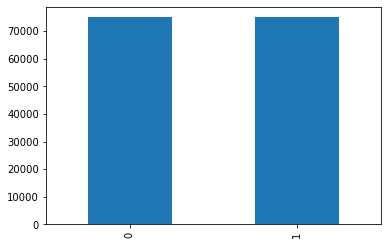

In [13]:
# 레이블 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [14]:
train_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,74991
1,1,74940


In [15]:
# 데이터 정제
# 정규표현식을 이용하여 한글을 제외하고 모두 제거해준다. 
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")
train_data['reviews'].replace('', np.nan, inplace = True)
train_data.isnull().sum()

C:\Users\user\AppData\Local\Temp\ipykernel_7624\4085793586.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")


ratings    0
reviews    0
label      0
dtype: int64

In [16]:
# test데이터에도 똑같이 해준다.
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


C:\Users\user\AppData\Local\Temp\ipykernel_7624\3625408796.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


### Tokenize

In [23]:
from konlpy.tag import Okt

In [25]:
okt = Okt() # Okt형태소 분석기 사용
okt.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔',stem = True)

['오다', '이렇다', '것', '도', '상품', '이라고', '차라리', '내', '가', '만들다', '게', '나다', '뻔']

In [27]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', 
             '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [28]:
train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [29]:
test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

KeyboardInterrupt: 

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))